In [5]:
from nltk import word_tokenize

In [2]:
# -*- coding: utf-8 -*-
import os
from os.path import basename

RAW = "../datasets/tweets_plus_notr"

sentiments = [os.path.join(RAW, file) for file in os.listdir(RAW)]

topic_dict = {}
for path in sentiments:
    if '.ipynb_checkpoints' in path: continue
    class_name = basename(path)
    text_list = []
    for file in os.listdir(path):
        if file.endswith('.txt'):
            with open(os.path.join(path, file),'r', encoding='utf-8') as f:
                try:
                    text = f.read()
                    text_list.append(text)
                except:
                    print(file)
                
    topic_dict[class_name] = text_list

In [3]:
topic_dict.keys()

dict_keys(['notr', 'olumlu', 'olumsuz'])

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

X_name = 'text'
y_name = 'category'

raw_datas = [{'text':[text for text in topic_dict[key]]} for key in topic_dict.keys()]
dataframes_X = [pd.DataFrame(raw_data, columns = [X_name]) for raw_data in raw_datas]
train_data_list, test_data_list = [],[] 
for idx,key in enumerate(topic_dict.keys()):
    dataframes_X[idx][y_name] = [key]*len(dataframes_X[idx])  
    train_dum, test_dum = train_test_split(dataframes_X[idx], test_size=0.2)
    train_data_list.append(train_dum)
    test_data_list.append(test_dum)


In [5]:
train_dataset = pd.concat(train_data_list, ignore_index=True).fillna(0)
test_dataset = pd.concat(test_data_list, ignore_index=True).fillna(0)
from sklearn.utils import shuffle
train_dataset = shuffle(train_dataset)
test_dataset = shuffle(test_dataset)

In [6]:
train_dataset = train_dataset.reset_index(drop=True)
test_dataset = test_dataset.reset_index(drop=True)

In [7]:
test_dataset.head()

,text,category
0,Turkcell Cüzdan hakkında Garanti'nin hiç bilgi...,olumsuz
1,Turkcell Enerji Şirketi Kuruyor... #Forex #IKO...,notr
2,Hayat Turkcell reklami kadar saçma .,olumsuz
3,Turkcell Samsung Galaxy S4 kampanyası,notr
4,yIldIz tilbe'li @turkcell reklamI yayInlansIn;...,notr


In [8]:
train_dataset.head()

,text,category
0,canIm arkadaSIm bipten nasIl Ucretsiz mesajlaS...,olumlu
1,@simgefstk @TurkcellHizmet iyi söyledin bende ...,notr
2,Turkcell reklamlarindaki o kucuk kizi alip bog...,olumsuz
3,9. İTÜ Robot Olimpiyatları | Geleceği Yazanlar...,notr
4,turkcell salla kazan kampanyasi tekrar baslami...,olumlu


In [9]:
sum([len(word_tokenize(text)) for text in train_dataset.text]) # /len(train_dataset.text)

196303

In [1]:
from zemberek import (
    TurkishSpellChecker,
    TurkishSentenceNormalizer,
    TurkishSentenceExtractor,
    TurkishMorphology,
    TurkishTokenizer
)
morphology = TurkishMorphology.create_with_defaults()
normalizer = TurkishSentenceNormalizer(morphology)
sc = TurkishSpellChecker(morphology)

2021-02-12 16:04:55,359 - zemberek.morphology.turkish_morphology - INFO
Msg: TurkishMorphology instance initialized in 26.676000118255615



In [3]:
examples = ["bılıyorum"]
# SENTENCE NORMALIZATION

for example in examples:
    print(normalizer.normalize(example), "\n")

biliyorum 



In [12]:
X_train = train_dataset.text
X_test = test_dataset.text

y_train = train_dataset.category
y_test = test_dataset.category

data = train_dataset.append(test_dataset, ignore_index=True)

In [4]:
import zeyrek
lemmatizer = zeyrek.MorphAnalyzer()
print(lemmatizer.lemmatize('muvaffakiyetlileştiremediklerimizden'))

2021-02-12 16:14:33,128 - root - WARNING
Msg: APPENDING RESULT: <(muvaffakiyet_Noun)(-)(muvaffakiyet:noun_S + a3sg_S + pnon_S + nom_ST + li:with_S + adjectiveRoot_ST + leş:become_S + verbRoot_S + tir:vCausTır_S + verbRoot_S + eme:vUnable_S + dik:vPastPart_S + noun_S + ler:a3pl_S + imiz:p1pl_S + den:abl_ST)>

[('muvaffakiyetlileştiremediklerimizden', ['muvaffakiyet'])]


In [13]:
from nltk.corpus import stopwords
import string
from snowballstemmer import TurkishStemmer
import zeyrek
from tqdm import tqdm
lemmatizer = zeyrek.MorphAnalyzer()
ts=TurkishStemmer()

def clean_text(data, stem=False, lemmatize=True, normalize=True):  
    # tekenization using nltk
    data = word_tokenize(data)
    
    remov = set(stopwords.words("turkish"))
   
    result_words = []
    for w in data:
        temp = w.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation))).split()
        result_words.extend(t for t in temp)
        
    words = [word.lower() for word in result_words]
    words = [w.strip() for w in words if '\n' or '' != w]
    words = [w for w in words if w not in remov]
    words = [x for x in words if not any(c.isdigit() for c in x)]
    words = [word for word in words if len(word) > 2]
    words_dum = []
    if normalize:
        for w in words:
            try:
                words_dum.append(normalizer.normalize(w))
            except:
                words_dum.append(w)
        words = words_dum
        
    words_dum = []
    if lemmatize:
        for w in words:
            try:
                words_dum.append(lemmatizer.lemmatize(w))
            except:
                words_dum.append(w)
    if stem:
        words = [ts.stemWord(w) for w in words]
    return words

In [15]:
embed_num_dims = 300

token_vocab_size = 10000

max_seq_len = 50

class_names = [key for key in topic_dict.keys()]

num_classes = len(class_names)

In [16]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [17]:
tokenizer = Tokenizer(num_words=token_vocab_size)
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 31363


In [18]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len, padding='pre', truncating='pre')
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len, padding='pre', truncating='pre')

X_train_pad

array([[   0,    0,    0, ...,  982,    1,  256],
       [   0,    0,    0, ..., 2402,  918,  451],
       [   0,    0,    0, ..., 1227, 1166,  497],
       ...,
       [   0,    0,    0, ...,    4,  362, 1570],
       [   0,    0,    0, ...,   25,  190,    1],
       [   0,    0,    0, ...,  114, 4307, 1715]])

In [19]:
encoding = {key:val for val,key in enumerate(topic_dict.keys()) }
y_train = [encoding[x] for x in train_dataset.category]
y_test = [encoding[x] for x in test_dataset.category]

In [20]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [22]:
from torchtext.vocab import FastText

my_vector = FastText('tr')

2021-02-12 00:38:21,089 - torchtext.vocab - INFO
Msg: Loading vectors from .vector_cache\wiki.tr.vec.pt



In [23]:
print(index_of_words['siyaset'])

5137


In [24]:
import numpy as np
def create_embedding_matrix(w2v_embeds, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word in word_index:
        idx = word_index[word]
        try:
            embed = w2v_embeds[word]
            embedding_matrix[idx] = np.array(
                embed, dtype=np.float32)[:embedding_dim]
        except:
            print(word)
    return embedding_matrix

In [25]:
embedd_matrix = create_embedding_matrix(my_vector, index_of_words, embed_num_dims)
embedd_matrix.shape

(31364, 300)

In [26]:
len(index_of_words)

31363

In [ ]:
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in fasttext vocab: ' + str(len(index_of_words) - new_words))
print('New words: ' + str(new_words))

In [28]:
import pandas as pd
import numpy as np

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, average_precision_score, recall_score, precision_score

# layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, MaxPooling1D
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional,SimpleRNN

In [29]:
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

In [31]:
# # Convolution
# kernel_size = 5
# filters = 256

# model = Sequential()
# model.add(embedd_layer)
# model.add(Dropout(0.5))
# model.add(Conv1D(filters, kernel_size, activation='relu'))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(filters, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))

In [32]:
## BiLSTM

# model = Sequential()

# model.add(embedd_layer)
# model.add(Dropout(0.4))
# model.add(Bidirectional(LSTM(embed_num_dims)))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))

In [33]:
## LSTM
model = Sequential()

model.add(embedd_layer)
model.add(Dropout(0.4))
model.add(LSTM(embed_num_dims))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

In [34]:
## SimpleRNN
# model = Sequential()

# model.add(embedd_layer)
# model.add(Dropout(0.4))
# model.add(SimpleRNN(embed_num_dims))
# model.add(Dropout(0.4))
# model.add(Dense(num_classes, activation='softmax'))

In [ ]:
opt =  keras.optimizers.Adam(lr=0.00005, decay=1e-6)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
model.summary()

In [ ]:
batch_size = 128
epochs = 50

hist = model.fit(X_train_pad, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test),verbose=1)

In [ ]:
# Accuracy plot
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# plt.savefig('figures_notr/LSTM_acc.png')
plt.show()

# Loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# plt.savefig('figures_notr/LSTM_loss.png')
plt.show()

In [356]:
# from keras.models import load_model
# predictor = load_model('models/cnn_w2v.h5')

In [178]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)

In [179]:
predictions = [class_names[pred] for pred in predictions]

In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(test_dataset.category, predictions) * 100))
print("F1 Score: {:.2f}".format(f1_score(test_dataset.category, predictions, average='weighted') * 100))
print("Precision: {:.2f}%".format(precision_score(test_dataset.category, predictions, average ='weighted') * 100))
print("Recall: {:.2f}%".format(recall_score(test_dataset.category, predictions, average ='weighted') * 100))

In [181]:
test_dataset.text[0]

'ben trabzonsporu tutuyorum diye öğrencilerimden bazıları da trabzonsporu tutmaya başladı turkcell gibiyim onları da hayata bağlıyorum :):)'

In [182]:
text = """bıktım"""
text = clean_text(text)
txt = [text]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_seq_len)
pred = model.predict(padded)
labels = [key for key in topic_dict.keys()] 
print(labels)
print(pred)
print(np.argmax(pred))
print(labels[np.argmax(pred)])

2021-02-09 16:37:19,216 - root - WARNING
Msg: APPENDING RESULT: <(bıkmak_Verb)(-)(bık:verbRoot_S + tı:vPast_S + m:vA1sg_ST)>

['notr', 'olumlu', 'olumsuz']
[[0.2507852 0.2137253 0.5354895]]
2
olumsuz


In [183]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          title,
                          cmap=plt.cm.Blues):

    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots()

    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

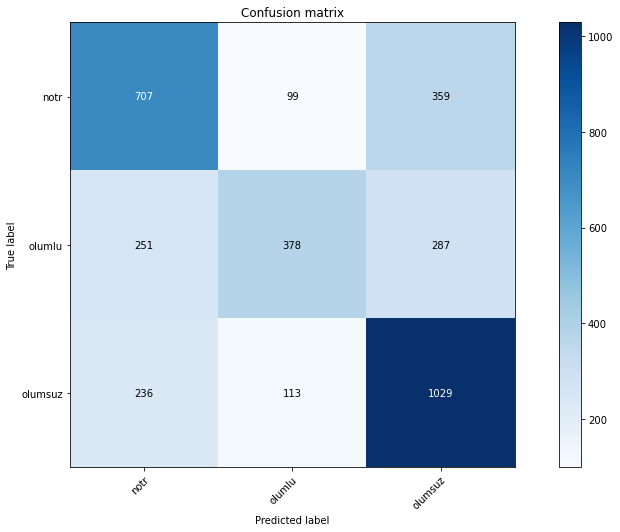

In [185]:
plot_confusion_matrix(test_dataset.category, predictions, classes=class_names, title='Confusion matrix')
# plt.savefig('figures_notr/LSTM_confusion.png')
plt.show()

In [186]:
# model.save('models_notr/LSTM_notr.h5')